# III. Opening a Sentinel-2 image with `Xarray`

---
**Author(s):** Quentin Yeche, Kenji Ose, Dino Ienco - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction

In this notebook we will cover basic manipulation of multi-band imagery with `Xarray`. This is the last step before reaching the most complex use case of multi-band and multi-date data. Fortunately the libraries and concepts we cover here will transfer to times series.

### Outline

In [section 3](#3-creating-a-dataarray-from-stac-object) we will see how to create an Xarray DataArray from a STAC object using `stackstack`.

[Section 4](#4-xarray-overview) is an overview of a DataArray, and explains what coordinates, dimensions, Indexes and Attributes are.

[Section 5](#5-indexing-and-selecting) attempts to provide a thorough introduction to filtering and selecting data in a DataArray.

In [section 6](#6-a-quick-introduction-to-xarraywhere) we will discuss some uses of the very powerful `where` method.

In [section 7](#7-plotting-data) we will learn how to plot data using Xarray's native commands

[Section 8](#8-extra-accessing-values-loading-and-compute) is an optional extra which provides some details on data loading and downloads when using DataArrays.

## 2. Library imports

As usual, we import all the required Python libraries. The new one is `xarray`, a package that makes working with labelled multi-dimensional arrays in Python simple, efficient, and fun! (*not sure*).

In [92]:
# this cell is only useful if you're using an environment like Google Collab or
# Microsoft Planetary Computer's servers
def test_import_or_install(imports):
  import importlib
  restart_needed = False
  for import_name, pip_name in imports:
    try:
      importlib.import_module(import_name, package=None)
    except ModuleNotFoundError:
      if not restart_needed:
          restart_needed= True
          print('\033[91m' + ("ONE OR MORE LIBRARIES HAVE TO BE INSTALLED, "
          "PLEASE RESTART THE NOTEBOOK AFTER THIS CELL FINISHES EXECUTING "
          "TO ENSURE PROPER FUNCTIONALITY") + "\x1b[0m")
      %pip install {pip_name}
  if restart_needed:
    print('\033[91m' + ("LIBRARIES HAVE BEEN INSTALLED. "
          "PLEASE RESTART THE NOTEBOOK NOW ") + "\x1b[0m")

imports = [('pystac_client', 'pystac-client'),
           ('planetary_computer', 'planetary-computer'),
           ('stackstac', 'stackstac')
           ]

test_import_or_install(imports)

In [93]:
# STAC access
import pystac_client
import planetary_computer

# dataframes
import pandas as pd

# xarrays
import xarray as xr

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# miscellanous
import numpy as np
from IPython.display import display


## 3. Creating a `DataArray` from a STAC object

### 3.1. Getting a Sentinel-2 STAC Item 

As a practical use case let's consider that we have identified the STAC Item we're interested in (see [this notebook](01-STAC.ipynb) for a refresher), and we also have an area of interest defined as a bounding box.

In [94]:
# retrieving the relevant STAC Item
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

# bounding box expressed in Lat/Lon
aoi_bounds = (3.875107329166124, 43.48641456618909, 4.118824575734205, 43.71739887308995)

item = catalog.get_collection('sentinel-2-l2a').get_item("S2A_MSIL2A_20201213T104441_R008_T31TEJ_20201214T083443")
#display(item)

assets = [asset.title for asset in item.assets.values()]
descriptions = pd.DataFrame(assets, columns=['Description'], index=pd.Series(item.assets.keys(), name='asset_key'))
descriptions

Description
asset_key                                                
AOT                       Aerosol optical thickness (AOT)
B01                        Band 1 - Coastal aerosol - 60m
B02                                   Band 2 - Blue - 10m
B03                                  Band 3 - Green - 10m
B04                                    Band 4 - Red - 10m
B05                  Band 5 - Vegetation red edge 1 - 20m
B06                  Band 6 - Vegetation red edge 2 - 20m
B07                  Band 7 - Vegetation red edge 3 - 20m
B08                                    Band 8 - NIR - 10m
B09                            Band 9 - Water vapor - 60m
B11                            Band 11 - SWIR (1.6) - 20m
B12                            Band 12 - SWIR (2.2) - 20m
B8A                 Band 8A - Vegetation red edge 4 - 20m
SCL                         Scene classfication map (SCL)
WVP                                    Water vapour (WVP)
visual                                   True color image
preview                                         Thumbnail
safe-manifest                               SAFE manifest
granule-metadata                         Granule metadata
inspire-metadata                         INSPIRE metadata
product-metadata                         Product metadata
datastrip-metadata                     Datastrip metadata
tilejson                  TileJSON with default rendering
rendered_preview                         Rendered preview

> <span style='color:red'> **IMPORTANT:** The URLs that we obtain from the STAC Catalog are not valid indefinitely. They expire after about 30 minutes. If you see an error in the notebook, it is likely because the URL that you obtained by running the first few cells has now expired.</span> If that happens you should be able to just run the notebook again from the top to get a new URL. You can get longer-lasting URLs by signing up for Planetary Computer (which is free at the time of writing this notebook). More info [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/). 

### 3.2. Using the `stackstac` library
Now that we have our STAC Item we will use `stackstac` in order to create a multi-dimensional array for our multi-band data. This library is very powerful and will handle in a single call a lot of small inconveniences: resampling, data types, CRS, etc.

The function [`stackstac.stack`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html#stackstac.stack) has quite a few parameters, but most values can often be left as default. Here are the ones we will be using here:
- `assets`. We don't want all the assets in the Item, especially since some of them are just metadata and have no dimension. Let's select all the bands: B02 through B08, B11 and B12
- `resolution`. As we can see in the table above, not all the bands have the same resolution. If we want them in a multi-dimensional array we need to choose a single resolution for all the bands. Here we choose 10 (for 10 meters), which means that the 20 and 60 meter bands will be resampled to 10 m. The `resampling` parameter can be added to specify which resampling method to use, but here the default value (`nearest`) is what we want.
- `dtype`. By default the data type is `float64`. Sentinel-2 data is almost always distributed as 16 bit integers. Thus we will use `uint16` which will save space and allow faster computations. See the note below for more details.
- `bounds_latlon` and `bounds`. Only one of the two can be used. Here we use the former, which allows us to directly specify a bounding box as latitude and longitude. On the other hand `bounds` requires using the correct coordinate system as defined by the `epsg` parameter if specified, or the `proj:epsg` property on the STAC assets (and in this case all assets must have the same CRS) if the `epsg` parameter is left as default.


In [95]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
array = stackstac.stack(
                    item,
                    assets = bands,
                    resolution=10,
                    bounds_latlon=aoi_bounds,
                    )

## 4. Xarray overview

### 4.1. Xarray structure

> **Note:** `Xarray` is the name of the library. The objects are called `DataArrays` but they tend to be called xarray regardless. In these notebooks we will favor 'DataArray' or simply 'array'.

DataArrays are multi-dimensional arrays. Some of the advantages over more traditional arrays such as NumPy arrays include the following options:
- naming dimensions,
- providing support for holding various metadata alongside the numeric data.

DataArrays can use one of two objects to actually hold the multi-dimensional array: either a **[NumPy](https://numpy.org/doc/stable/user/absolute_beginners.html) array** or a **Dask array**. Dask is designed to handle large arrays that don't fit into memory. It also enables streaming. We created this DataArray from the URL we got from the STAC Catalog. As long as the values of the array are not explicitly needed for computation, they will not be downloaded and loaded into memory.

`Xarray` is closely related to `pandas` and `NumPy`. `DataArray` dimensions use pandas Index, and as mentioned previously the multi-dimensional array can be a NumPy object. Most NumPy methods have a DataArray equivalent. Just like pandas dataframes and NumPy arrays, Xarray does not do in-place processing. This means that most operations on a DataArray do not modify the array, they return a new modified array instead.

> **Note:** It may seem wasteful and/or slow to create new objects instead of modifying them. But Xarray, NumPy and pandas were developed with this in mind so they are well optimized to that effect. In fact it is much more of a stylistic choice (i.e. how the code is written) than a fundamental inability to modify objects.


In [96]:
#display the xarray object's structure

array

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 373MB
dask.array<fetch_raster_window, shape=(1, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

DataArrays display very nicely as the last line in cell (or with a `IPython.display.display` call). From this visualization we can already gather a lot of information about our data and DataArray in general.

The first table and accompanying cube visual essentially show the same information. First of all the table is separated into two columns: array and chunks. Arrays are divided into chunks for reasons of efficiency. If you need to perform a lot of calculations on big arrays, it can become necessary to choose an appropriate chunk size to allow for better computation

The rows of the table are fairly self-explanatory. The `Bytes` row gives the size of the array and a single chunk. It is important to note that even if the size is given, it does not mean that the data has been loaded. In fact at this point in the code the DataArray is created but the data has not been downloaded. But the size can still be calculated from the dimensions of the array and the data type.

The visual on the right give a geometric interpretation to the table data. The rectangular cuboid on the right is a representation of the 2 spatial dimensions as well as the 9 bands we selected. We can see that the spatial dimensions are separated into 3 rows and 2 columns. These smaller sections are the chunks. By looking at the table we can see that the chunks have spatial dimensions 1024 x 1024. Given our array of dimensions 1999 x 2590, the number of chunks is coherent.

The smaller square at the top-left represents the extra time dimension (of size 1 in this case since this is single-date data).

### 4.2. Coordinates and dimensions
> **Note:** The name Coordinate can be confusing, especially since it does not inherently relate to spatial coordinates of any kind. DataArrays are used in fields other than GIS, but the terminology still applies. Feel free to understand "coordinates" as "metadata which may be aligned along the dimensions of the array".

If we look at the Coordinates section we can see a lot of different rows. Feel free to explore these coordinates. You can see more about a coordinate by clicking the grey icon (stacked disks) to the right. You can also look at some coordinates more specifically with `array['coordinate_name']` or `array.coordinate_name`.

In [97]:
array

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 373MB
dask.array<fetch_raster_window, shape=(1, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

Here 4 of the rows in the Coordinates section have names in bold (or * before their names if you prefer using `print(array`) instead): `time`, `band`, `x` and `y` . These coordinates are also **dimensions**. They are named dimensions, which means that we will be able to select data by directly specifying the dimension name. The dimensions contain values called labels, which permits selecting by these labels rather than using indices. For example in `array` the second dimension has the name `band` and 9 labels associated with it: `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B11`, and `B12`.

Most of the other coordinates can be seen as metadata gathered from the STAC Assets: the CRS, some information about the satellite, the cloud cover, full names for the bands... This is one of the advantage of Xarray: we can keep the relevant metadata as we perform calculations on the underlying numeric values.

The second colum in the coordinate table can be useful. It indicates to which dimension the coordinate relates to. As an obvious example let's consider the `title` coordinate. This coordinate refers to the full human-readable names of the bands. The row has `(band)` in the second column. This means that the `title` coordinate contains an array of the same size as the `band` dimension, and the values it contains refer to the same positions.

In the following cell we can see that the `title` coordinate is itself an DataArray with a single dimension : `band`.

On the other hand, most of the metadata we have in Coordinates has nothing specified for the second column. It simply means that there are no dimensions associated with these properties. Indeed values like `orbit` or `proj:epsg` don't have any dimensional aspect, they're just properties of the whole array.

In [98]:
# these two syntaxes are strictly equivalent
array['title']
array.title

<xarray.DataArray 'title' (band: 9)> Size: 1kB
array(['Band 2 - Blue - 10m', 'Band 3 - Green - 10m',
       'Band 4 - Red - 10m', 'Band 5 - Vegetation red edge 1 - 20m',
       'Band 6 - Vegetation red edge 2 - 20m',
       'Band 7 - Vegetation red edge 3 - 20m', 'Band 8 - NIR - 10m',
       'Band 11 - SWIR (1.6) - 20m', 'Band 12 - SWIR (2.2) - 20m'],
      dtype='<U36')
Coordinates: (12/40)
  * band                                     (band) <U3 108B 'B02' ... 'B12'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631

In [99]:
# this coordinate name contains a colon ':'
# which cannot be used in a Python name
# so this is the only syntax which will work
array['proj:epsg']

<xarray.DataArray 'proj:epsg' ()> Size: 8B
array(32631)
Coordinates: (12/34)
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    eo:cloud_cover                           float64 8B 17.23
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    platform                                 <U11 44B 'Sentinel-2A'
    s2:processing_baseline                   <U5 20B '02.12'
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    epsg                                     int64 8B 32631

#### 4.2.1. Looking at the `x` and `y` dimensions

It is fairly obvious that the `band` dimension contains the labels for the bands: `B02`, `B03` and so on. Similarly, the `time` dimension contains the date label (just one in this case). However the nature of the labels of the `x` and `y` dimensions is not necessarily obvious. These labels are the spatial coordinates for the pixels in the relevant CRS (in this case EPSG:32631, as specified by the `epsg` coordinate). By default the coordinates are for the top-left corner of the pixel, but it is possible to choose the center as the reference by using the `xy_coords` argument for `stackstac.stack`.

> **Note:** Since we chose 10 meter as our common resolution, it makes sense that these spatial coordinates are incremented by 10 with every pixel.

In [100]:
display(array.x)
display(array.y)

<xarray.DataArray 'x' (x: 1999)> Size: 16kB
array([570490., 570500., 570510., ..., 590450., 590460., 590470.])
Coordinates: (12/35)
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    platform                                 <U11 44B 'Sentinel-2A'
    s2:processing_baseline                   <U5 20B '02.12'
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    epsg                                     int64 8B 32631

<xarray.DataArray 'y' (y: 2590)> Size: 21kB
array([4841100., 4841090., 4841080., ..., 4815230., 4815220., 4815210.])
Coordinates: (12/35)
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    platform                                 <U11 44B 'Sentinel-2A'
    s2:processing_baseline                   <U5 20B '02.12'
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    epsg                                     int64 8B 32631

Here's how to understand the `x` and `y` dimension labels with an example. The third label of the dimension `x` is 570510, and the second label for `y` is 4841090. This means that the top-left corner of the pixel located at (3, 2) in the array (i.e. third column from the left, and second row from the top) maps to the geometric point with coordinates (570510, 4841090) in EPSG:32631.

### 4.3. Indexes and Attributes

The Indexes are simply the values associated with each dimension, available as a PandasIndex object. They can be useful in some situations, but those uses will not be covered here.

Finally the Attributes section contain some information about our imagery: the CRS, the affine transformation which links the spatial coordinates with row/column coordinates in the array, and the resolution. These Attributes would be used and modified if we were to re-project or resample our data.

## 5. Indexing and selecting

### 5.1. Different ways to select data in a DataArray

When deciding to filter and select data in an DataArray there are two choices to make:
 1. Are we we referring to the dimension by its name or by its position?
 2. Are we using the dimension labels are simply the positional indices?

Since these two choices are independent, this leads to four different ways to select data in a DataArray, summarized in the table below:


| Dimension lookup | Index lookup | Syntax                |
|------------------|--------------|-----------------------|
| Positional       | By integer   | `array[:, 0]`         |
| Positional       | By label     | `array.loc[:, 'B02']` or <br> `array.loc[dict(band='B02')]`    |
| By name          | By integer   | `array.isel(band=0)` |
| By name          | By label     | `array.sel(band='B02')`  |

In [101]:
(
    (array[:,0]).equals(array.loc[:,'B02']) and
    (array[:,0]).equals(array.isel(band=0)) and
    (array[:,0]).equals(array.sel(band='B02'))
)

True

In most cases, the `sel` method is the most convenient, so we will favor it. The `isel` method is useful in situations where the integer index has a meaning. For example if we want to manipulate our current array as if it were a regular image `sel` would be interesting to specify row/column values instead of spatial coordinates.

> **Note:** The two methods which use brackets have one advantage compared to `sel` and `isel`: they allow assigning values from a selection.

In [102]:
array2 = array.copy(deep=True)
print(f"Value before assignment: {array2.loc[dict(band='B02', x=570490, y=4841100)].values}")
array2.loc[dict(band='B02', x=570490, y=4841100)] = 0
print(f"Value after assignment: {array2.loc[dict(band='B02', x=570490, y=4841100)].values}")

# If you uncomment the following line and try to execute, it will fail
# Indeed sel() and isel() are function calls, so they don't support assignment.
#array2.sel(band='B02', x=570490, y=4841100) = 0


Value before assignment: [104.]
Value after assignment: [0.]


### 5.2. Selecting single values

The simplest use case is to select with a single value per dimension. Note that it is possible to chain multiple selections

In [103]:
filtered = array.sel(band='B02').isel(x=658)
display(filtered)
filtered.dims

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1, y: 2590)> Size: 21kB
dask.array<getitem, shape=(1, 2590), dtype=float64, chunksize=(1, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
    band                                     <U3 12B 'B02'
    x                                        float64 8B 5.771e+05
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      float64 8B 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              <U7 28B 'blue'
    center_wavelength                        float64 8B 0.49
    full_width_half_max                      float64 8B 0.098
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

('time', 'y')

It is interesting to note that after selecting with a unique value for `band` and `x`, they still appear in coordinates but they are no longer dimensions.

 > **Exercise:** Do the same selection (band and x coordinate) using positional dimension lookup instead

In [104]:
# to fill
# ...
# ...

### 5.3 Selecting multiple values

There are multiple way to select multiple values at once. The easiest to simply put the labels (resp. integer indices) as a list in `sel` (resp. `sel`). It is important to note that the order the values are given will be the order for the selection:

In [105]:
selection = array.sel(band=['B04', 'B02'])
display(selection)

print(selection.band.values)


<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 2,
                                                                y: 2590, x: 1999)> Size: 83MB
dask.array<getitem, shape=(1, 2, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B02'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 16B 10.0 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 56B 'red' 'blue'
    center_wavelength                        (band) float64 16B 0.665 0.49
    full_width_half_max                      (band) float64 16B 0.038 0.098
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

['B04' 'B02']


> **Note:** This time the dimension `x` is kept as multiple values still exist for it.

 > **Exercise:** Select the first 10 pixels in both the x and y dimensions, with only one call to `.sel`
 

In [106]:
# to fill
# ...
# ...

### 5.4 Using boolean masks for selections
Boolean masks are very powerful as they allow performing very diverse filtering operations.

If we want to select a multiple possible values for a dimension, we can use a boolean mask with `isin`: 

In [107]:
mask_x = array.band.isin(['B02', 'B04', 
                        'this label does not exist',
                        'but it doesn matter'])
display(mask_x)

<xarray.DataArray 'band' (band: 9)> Size: 9B
array([ True, False,  True, False, False, False, False, False, False])
Coordinates: (12/40)
  * band                                     (band) <U3 108B 'B02' ... 'B12'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631

In [108]:
filtered = array.sel(band=mask_x)
display(filtered)
filtered.dims

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 2,
                                                                y: 2590, x: 1999)> Size: 83MB
dask.array<getitem, shape=(1, 2, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 24B 'B02' 'B04'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 16B 10.0 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 56B 'blue' 'red'
    center_wavelength                        (band) float64 16B 0.49 0.665
    full_width_half_max                      (band) float64 16B 0.098 0.038
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

('time', 'band', 'y', 'x')

There are two differences compared to the previous method of specifying a list directly:
 - with a list all the values must appear in the dimension, or an error occurs.
 - with a list the values are selected in the order that they appear. With a boolean mask the original order of the array is preserved

One issue  of boolean masking is that in a single mask you must restrict yourself to a single dimension. But it is possible to use multiple masks at once

In [109]:
mask_x = (array.x%20 == 0) & (array.x%30 == 0) | (array.x < 578340)
mask_y = (array.y > 4840000)
array.sel(x=mask_x, y=mask_y)


<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9,
                                                                y: 110, x: 988)> Size: 8MB
dask.array<getitem, shape=(1, 9, 110, 988), dtype=float64, chunksize=(1, 1, 110, 988), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 8kB 5.705e+05 ... 5....
  * y                                        (y) float64 880B 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

 > **Exercise:** Try to explain what the previous cell masking does

### 5.5 Selecting based on a coordinate

Selection only works on dimensions. However there is a workaround to select based on a coordinate which isn't a dimension. Consider the following cell:

In [110]:
display(array.band)

<xarray.DataArray 'band' (band: 9)> Size: 108B
array(['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12'],
      dtype='<U3')
Coordinates: (12/40)
  * band                                     (band) <U3 108B 'B02' ... 'B12'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631

If we look at the Coordinates for this we can see that the `band` dimension, which is itself a DataArray, has kept all the coordinates which are not 'attached' to another dimension. This means that we can do the following:

In [111]:
mask = (array.band.title == 'Band 2 - Blue - 10m')
display(mask)
array.sel(band=mask)

<xarray.DataArray 'title' (band: 9)> Size: 9B
array([ True, False, False, False, False, False, False, False, False])
Coordinates: (12/40)
  * band                                     (band) <U3 108B 'B02' ... 'B12'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    s2:datatake_id                           <U34 136B 'GS2A_20201213T104441_...
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 1,
                                                                y: 2590, x: 1999)> Size: 41MB
dask.array<getitem, shape=(1, 1, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 12B 'B02'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 8B 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 28B 'blue'
    center_wavelength                        (band) float64 8B 0.49
    full_width_half_max                      (band) float64 8B 0.098
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

### 5.6 Selecting in a range and slices

Although it is possible to do it with a boolean mask of two conditions, selecting in a range (spatially or a range of dates) is a fairly typical use case, so more dedicated tools exist. We use Python `slice` objects. What follows is a small introduction to slicing if you're not familiar with that concept.

#### 5.6.1 Refresher on slicing

In Python there are data types called sequences. Lists and arrays are examples of sequences. One characteristic of sequences is the ability to access elements in a variety of ways. The most basic way is to just access an element

In [112]:
seq = list(chr(i+97) for i in range(10))
print(f"initial list: {seq=}\n")
      
print("accessing with just an index")
print(f"{seq[3]=}, {seq[-1]=}, {seq[-2]=}\n") # negative values start from the end

initial list: seq=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

accessing with just an index
seq[3]='d', seq[-1]='j', seq[-2]='i'



But we can also use a very similar syntax called slicing to select and create sub-lists:

In [113]:
print("accessing a range")
print(f"{seq[2:5]=}\n")

print("accessing a range and leaving some arguments blank")
print(f"{seq[:5]=}") # equivalent to a[0:5]
print(f"{seq[3:]=}\n") # equivalent to a[3:-1]

print("accessing with a step")
print(f"{seq[::2]=}") # every two elements
print(f"{seq[::-2]=}") # every two elements in reverse

accessing a range
seq[2:5]=['c', 'd', 'e']

accessing a range and leaving some arguments blank
seq[:5]=['a', 'b', 'c', 'd', 'e']
seq[3:]=['d', 'e', 'f', 'g', 'h', 'i', 'j']

accessing with a step
seq[::2]=['a', 'c', 'e', 'g', 'i']
seq[::-2]=['j', 'h', 'f', 'd', 'b']


This kind of slicing is fairly easy to understand. But sometimes writing all of this manually can be troublesome, especially if we want to slice multiple sequences in the same way, or if we want to consider a way to slice independently of a specific object. This is what `slice` objects are for. They allow to turn this `x:y:z` syntax into an object we can reuse. The syntax of slice is: `slice(start, stop, step)`. Only `stop` is mandatory, `start` and `stop` are optional and will be replaced with `None` if not specified. Here are some example of slicing the same list with slice objects:


In [114]:
seq = list(chr(i+97) for i in range(10))
print(f"initial list: {seq=}\n")

print("accessing a range")
print(f"{seq[slice(2,5)]=}\n")

print("accessing a range with just a stop value")
print(f"{seq[slice(5)]=} \n") #equivalent to a[slice(0,5)]
print("accessing a range with just a start value")
print(f"{seq[slice(3, None)]=}\n") #equivalent to a[slice(3,-1)]

print("accessing with a step")
print(f"{seq[slice(None, None, 2)]=}") #every two elements
print(f"{seq[slice(None, None, -2)]=}") #every two elements in reverse

initial list: seq=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

accessing a range
seq[slice(2,5)]=['c', 'd', 'e']

accessing a range with just a stop value
seq[slice(5)]=['a', 'b', 'c', 'd', 'e'] 

accessing a range with just a start value
seq[slice(3, None)]=['d', 'e', 'f', 'g', 'h', 'i', 'j']

accessing with a step
seq[slice(None, None, 2)]=['a', 'c', 'e', 'g', 'i']
seq[slice(None, None, -2)]=['j', 'h', 'f', 'd', 'b']


Of course it makes little sense to write `a[slice(x,y,z)]` instead of `a[x:y:z]`. Here's a more typical if simplistic reason to use `slice` objects:

In [115]:
letters = list(chr(i+97) for i in range(10))
letter_numbers = list(i for i in range(10))
print(f"{letters=}")
print(f"{letter_numbers=}\n")

print("let's slice both lists with the same object")
s = slice(3,8,2)
print(f"{letters[s]=}")
print(f"{letter_numbers[s]=}")

letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
letter_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

let's slice both lists with the same object
letters[s]=['d', 'f', 'h']
letter_numbers[s]=[3, 5, 7]


#### 5.6.2. Using slice objects with `sel` or `isel`

Selecting with with  a slice object is fairly straight-forward:

In [116]:
array.sel(x=slice(580000, 580100), y=slice(None, None, 500))

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9, y: 6,
                                                                x: 11)> Size: 5kB
dask.array<getitem, shape=(1, 9, 6, 11), dtype=float64, chunksize=(1, 1, 3, 11), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 88B 5.8e+05 ... 5.80...
  * y                                        (y) float64 48B 4.841e+06 ... 4....
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

In [117]:
array.sel(x=580000)

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9, y: 2590)> Size: 186kB
dask.array<getitem, shape=(1, 9, 2590), dtype=float64, chunksize=(1, 1, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
    x                                        float64 8B 5.8e+05
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

 > **Exercise:** Using slices, select all at once:
 1. all bands between B02 and B08 included, 
 2. every other pixel along the x dimension starting at the coordinate 580000
 3. every pixel along the y dimension at index positions between 10 and 100

**Hint:** You will need to use both `.sel`and `.isel`

In [118]:
# to fill
# ...
# ...

However there are **three important details** to keep in mind.
 - Contrary to slicing with lists or NumPy arrays, both bounds are included. This means that `slice(a,b)` also includes `b`
 - When we use `sel`, the slice arguments we use are values, not indices.
 - Despite the previous point, the selection is still operated on indices
 
This means that when writing `sel(x=slice(a,b))`, the operation is equivalent to the following:
 1. Find the index with value `a`. Let's name it `id_a`
 2. Find the index with value `b`. Let's name it `id_b`
 3. If `id_a` > `id_b` then return nothing
 4. Else return all the values with indices between `id_a` and `id_b` (bounds included).

These quirks can often show when dealing with unsorted dimensions. What follows is a small example with an unsorted dimension `x`.

In [119]:
x = np.array([3, 1, 2, 7, 6, 4, 5, 0])  # Values for the first dimension (not sorted)
y = np.arange(3)  # Values for the second dimension


data = np.random.rand(len(x), len(y))  # Random data values

# Create the DataArray
ds = xr.DataArray(data, coords={'x': x, 'y': y}, dims=['x', 'y'])

ds

<xarray.DataArray (x: 8, y: 3)> Size: 192B
array([[0.7993549 , 0.82180294, 0.81647943],
       [0.06549832, 0.89944711, 0.45513839],
       [0.60993834, 0.37302759, 0.38741135],
       [0.22048715, 0.83627181, 0.93822748],
       [0.84695097, 0.28720396, 0.82613858],
       [0.66124529, 0.37636547, 0.29095491],
       [0.25386919, 0.87048983, 0.03471738],
       [0.241697  , 0.9745244 , 0.17123118]])
Coordinates:
  * x        (x) int64 64B 3 1 2 7 6 4 5 0
  * y        (y) int64 24B 0 1 2

In [120]:
display(ds.sel(x=slice(1,4)).x) #still includes 7 and 6 since indices are used
display(ds.sel(x=slice(5,7)).x) #nothing is selected since 5 comes after 7 in the order
ds.sel(x=slice(7,5)).x #this selects correctly

<xarray.DataArray 'x' (x: 5)> Size: 40B
array([1, 2, 7, 6, 4])
Coordinates:
  * x        (x) int64 40B 1 2 7 6 4

<xarray.DataArray 'x' (x: 0)> Size: 0B
array([], dtype=int64)
Coordinates:
  * x        (x) int64 0B

<xarray.DataArray 'x' (x: 4)> Size: 32B
array([7, 6, 4, 5])
Coordinates:
  * x        (x) int64 32B 7 6 4 5

This somewhat surprising behavior is part of the reason why using unsorted dimensions is usually discouraged. Similarly, dimensions don't necessarily need to have unique values, but this also leads to confusing behavior. Fortunately in remote sensing we rarely if ever encounter these situations.

## 6. A quick introduction to `xarray.where`

This section aims to show a few uses for [`xarray.where`](https://docs.xarray.dev/en/stable/generated/xarray.where.html). This function is a useful tool in many situations. It enables selecting data from arrays/DataArrays based on a boolean condition. Its signature is the following `xarray.where(cond, x, y)`:
 - `cond` is the boolean condition. It can be a scalar, an array or an DataArray
 -  `x` values to choose from where `cond` is True
 - `y` values to choose from where `cond` is False

In [121]:
seq = np.arange(10)
print(seq)
xr.where(seq>5, 0, seq)

[0 1 2 3 4 5 6 7 8 9]


array([0, 1, 2, 3, 4, 5, 0, 0, 0, 0])

This first example is trivial, but it captures the essence of the `where` function. The complexity lies in writing the right boolean condition, and understanding the shapes of the objects involved.

This function is a very useful tool to mask and create a modified array fairly easily based on conditions:

In [122]:
print(f'Max before clipping = {array.max().values}')
clipped = xr.where(array>2000, 2000, array) #useful for clipping values before creating visuals
print(f'Max after clipping = {clipped.max().values}')

Max before clipping = 16032.0
Max after clipping = 2000.0


In [123]:
array2 = xr.where(array.band=='B02', 0, array)
print('Band B02')
display(array2.sel(band='B02').values)
print('\nBand B03')
display(array2.sel(band='B03').values)


Band B02


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])


Band B03


array([[[ 268.,  326.,  301., ..., 3894., 3840., 3848.],
        [ 403.,  412.,  473., ..., 3824., 3868., 3882.],
        [ 416.,  381.,  323., ..., 3920., 3916., 3902.],
        ...,
        [ 187.,  187.,  160., ...,  396.,  394.,  422.],
        [ 195.,  187.,  150., ...,  425.,  392.,  406.],
        [ 199.,  166.,  158., ...,  427.,  411.,  372.]]])

 > **Exercise:** Why did the two previous cells take much longer to execute ?

## 7. Plotting data

### 7.1 First attempt

Yet another advantage of Xarray is that it directly includes a lot of plotting tools from the `matplotlib` library. Let's play with them a bit. Since we are going to make a lot of calls to the underlying data array, this is one situation where using `compute` to force the data into memory is a good choice.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..16032.0].


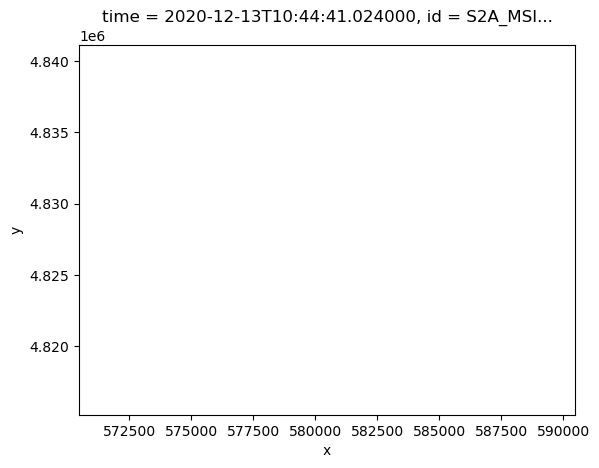

In [147]:
# We only take the visible bands for our visualization
bs = array.band.isin(['B02', 'B03', 'B04'])
ds_bands = array.sel(band=bs).isel(time=0).compute()

ds_bands.plot.imshow()

This first plot definitely leaves a lot to be desired. Let's try to improve it step by step.

### 7.2 Contrast and normalization

 Conveniently the `imshow` function printed out a warning that the values have been clipped. This explains the overabundance or white since all of our values are above 1. This can be confirmed by running a quick histogram on values:

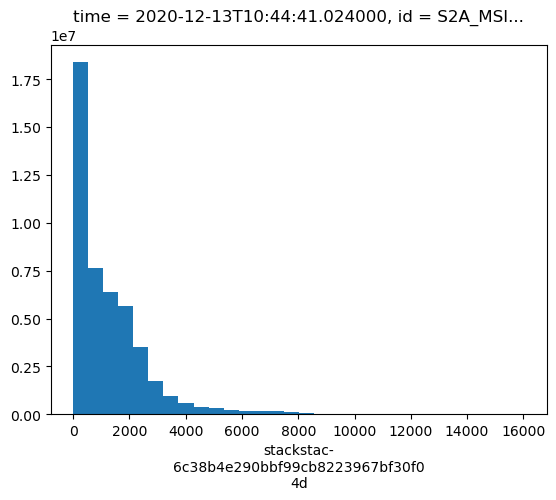

In [143]:
ds_bands.plot.hist(bins=30)
plt.show() #not strictly necessary but it supresses some ugly output

#### 7.2.1 Contrast and normalization: the manual approach

Let's see how to adjust the values so that they fit between 0 and 1. For satellite imagery, min-max normalization is usually not enough since there are usually a few outlier pixels with very high values. This can be seen in the histogram above (everything above 2500 or so in this case)

First we will clip the values above the 95th percentile

In [148]:
# we specify the spatial dimensions because we want
# a value for each band separately
quantile = ds_bands.quantile(.95, dim=['x','y'])
display(quantile)
# xr.where is useful here
ds_bands_clipped = xr.where(ds_bands<quantile, ds_bands, quantile)

<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (band: 3)> Size: 24B
array([2820., 2968., 2994.])
Coordinates:
  * band                 (band) <U3 36B 'B02' 'B03' 'B04'
    title                (band) <U36 432B 'Band 2 - Blue - 10m' ... 'Band 4 -...
    gsd                  (band) float64 24B 10.0 10.0 10.0
    common_name          (band) <U7 84B 'blue' 'green' 'red'
    center_wavelength    (band) float64 24B 0.49 0.56 0.665
    full_width_half_max  (band) float64 24B 0.098 0.045 0.038
    quantile             float64 8B 0.95

Now that we've clipped the values we can normalize the range so that the values fall between 0 and 1. To do that, we can simply calculate the following:

$$z_i = {p_i−min(p) \over max(p)−min(p)}$$

where $p=(p_1,...,p_n)$
and $z_i$ is now your $i^{th}$ normalized pixel

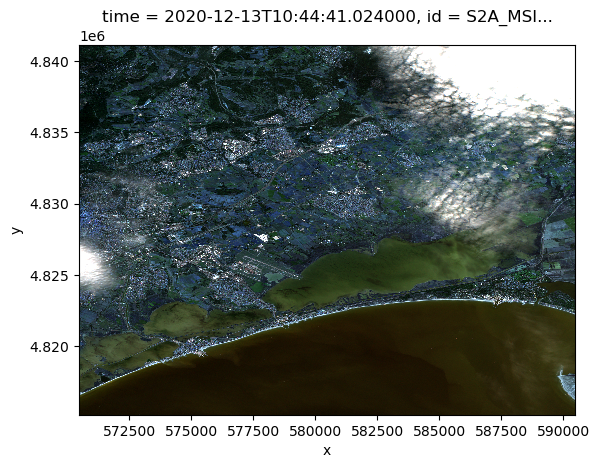

In [149]:
bands_max = ds_bands_clipped.max(dim=['x', 'y'])
bands_min = ds_bands_clipped.min(dim=['x', 'y'])
ds_bands_clipped = (ds_bands_clipped - bands_min)/(bands_max - bands_min)
ds_bands_clipped.plot.imshow()

#### 7.2.2 Adjusting with `imshow` directly

This last part was a useful way to learn about functions like `quantile` and performing simple calculations. But rather than having to deal with contrast by hand, we can use some more convenient parameters of `imshow`. 

The first are `vmax` and `vmin`. They allow to specify cutoff bounds. Any value lower than `vmin` will be treated as equal to `vmin`. Same goes for `vmax`, but with values higher than `vmax`. When either `vmax` or `vmin` is specified, the normlization betewen `vmin` and `vmax` is also handled by `imshow`:

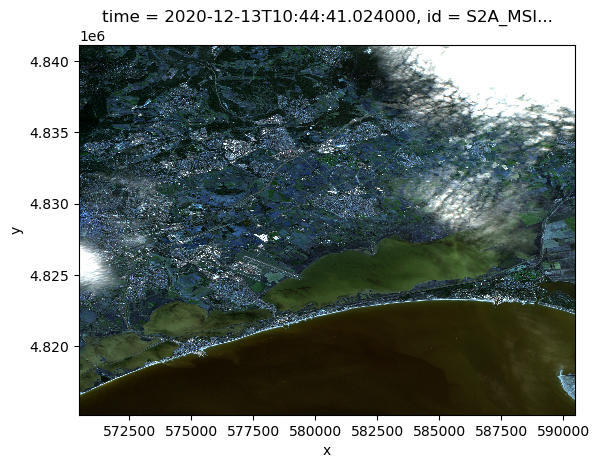

In [150]:
# we choose vmax close to the 95th percentile
# we found previously
ds_bands.plot.imshow(vmax=2900)

The second option is even more straightforward: `robust`. It doesn't require specifying any value, and it will compute the 2nd and 98th percentiles to be used as `vmin` and `vmax`:

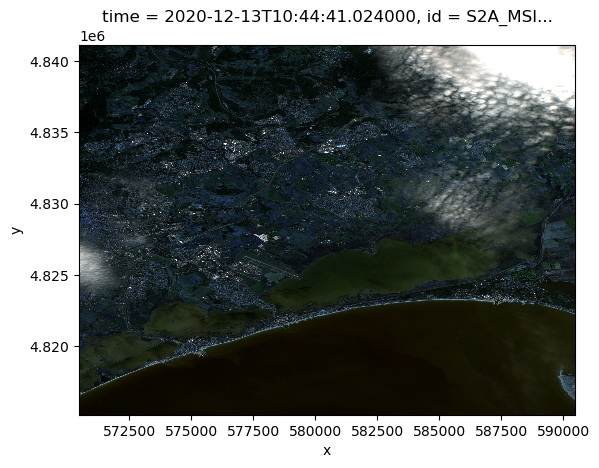

In [153]:
#98th percentile means the image is overall darker since there are more outlier in the high values
ds_bands.plot.imshow(robust=True)

These parameters are very useful to produce very quick visuals. However they also are less customizable. With `robust` there is no way to choose the percentiles. With both `robust` and `vmax`/`vmin`, only a single value is computed for all the bands. In this case we can see that the percentiles are similar for all 3 bands so it doesn't matter much, but it is not always the case.

Now we can finally see something! However there are still a few things to do to improve this hellish landscape!

### 7.3 Band order
The next thing to notice is that the colors are all wrong. The brown/orange at the bottom is supposed to be the sea. 

Sentinel-2 names its bands in order of increasing wavelengths, from blue to red to infrared.

In [154]:
ds_bands.title

<xarray.DataArray 'title' (band: 3)> Size: 432B
array(['Band 2 - Blue - 10m', 'Band 3 - Green - 10m',
       'Band 4 - Red - 10m'], dtype='<U36')
Coordinates: (12/42)
    time                                     datetime64[ns] 8B 2020-12-13T10:...
    id                                       <U54 216B 'S2A_MSIL2A_20201213T1...
  * band                                     (band) <U3 36B 'B02' 'B03' 'B04'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    ...                                       ...
    gsd                                      (band) float64 24B 10.0 10.0 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 84B 'blue' 'green' 'red'
    center_wavelength                        (band) float64 24B 0.49 0.56 0.665
    full_width_half_max                      (band) float64 24B 0.098 ... 0.038
    epsg                                     int64 8B 32631

We can indeed see that our bands are in BGR order, while the default standard for bands in regular images is RGB. There are three ways to deal with this issue:
 - using the convenient `center_wavelength` coordinate to sort our bands in descending order of wavelength with `sortby`
 - using advanced vectorized indexing
 - using a slice object to reverse the order in a selection

In [161]:
# sortby
display(ds_bands.sortby('center_wavelength', ascending=False).band)

# vectorized indexing on the first dimension
# which is band
display(ds_bands.loc[['B04','B03','B02']].band)


# slice object
ds_bands = ds_bands.sel(band=slice(None, None, -1))
ds_bands.band

<xarray.DataArray 'band' (band: 3)> Size: 36B
array(['B04', 'B03', 'B02'], dtype='<U3')
Coordinates: (12/42)
    time                                     datetime64[ns] 8B 2020-12-13T10:...
    id                                       <U54 216B 'S2A_MSIL2A_20201213T1...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    ...                                       ...
    gsd                                      (band) float64 24B 10.0 10.0 10.0
    proj:bbox                                object 8B {609780.0, 4790220.0, ...
    common_name                              (band) <U7 84B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32631

<xarray.DataArray 'band' (band: 3)> Size: 36B
array(['B04', 'B03', 'B02'], dtype='<U3')
Coordinates: (12/42)
    time                                     datetime64[ns] 8B 2020-12-13T10:...
    id                                       <U54 216B 'S2A_MSIL2A_20201213T1...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    ...                                       ...
    gsd                                      (band) float64 24B 10.0 10.0 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 84B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32631

<xarray.DataArray 'band' (band: 3)> Size: 36B
array(['B04', 'B03', 'B02'], dtype='<U3')
Coordinates: (12/42)
    time                                     datetime64[ns] 8B 2020-12-13T10:...
    id                                       <U54 216B 'S2A_MSIL2A_20201213T1...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
    sat:relative_orbit                       int64 8B 8
    instruments                              <U3 12B 'msi'
    s2:thin_cirrus_percentage                float64 8B 1.399
    ...                                       ...
    gsd                                      (band) float64 24B 10.0 10.0 10.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 84B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32631

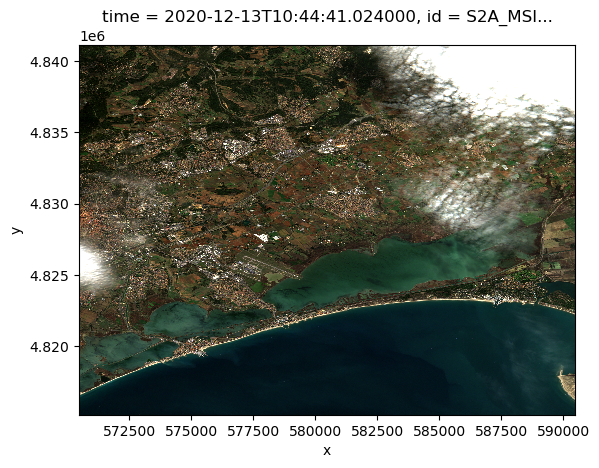

In [162]:
ds_bands.plot.imshow(vmax=2900)

### 7.4. Aspect ratio

The last issue with our visual is that the aspect ratio is wrong. For some reason, by default the pixels of the array don't have to be squares with `imshow`. We can forcibly specify an aspect ratio by using the `aspect` parameter. However we also must specify the `size` parameter which is  the height in inches of the plot.

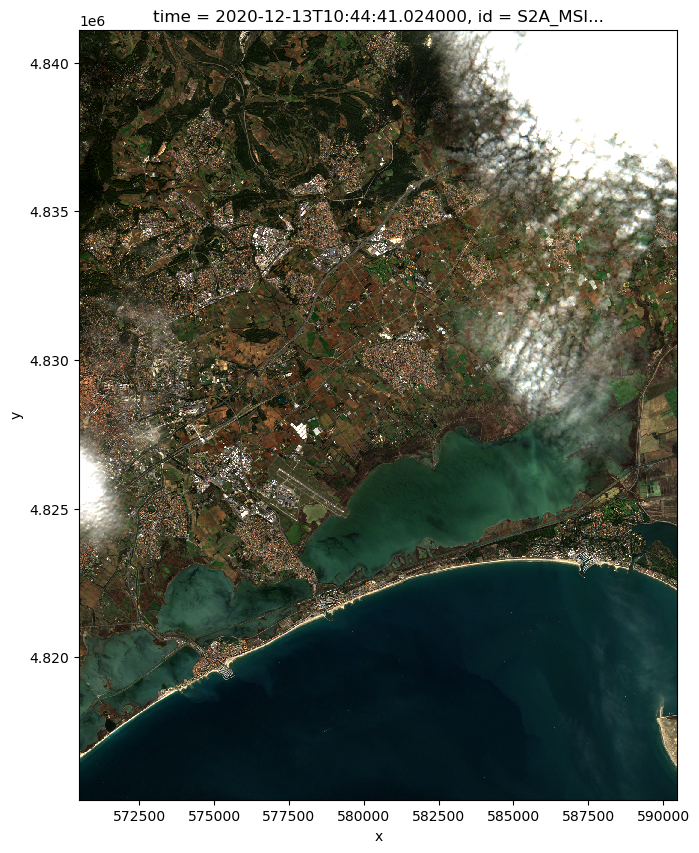

In [163]:
# calculating the aspect ratio as the
# size of the x dimension divided by
# the size of the y dimension
aspect = ds_bands.x.shape[0]/ds_bands.y.shape[0]

ds_bands
ds_bands.plot.imshow(vmax=2900, aspect=aspect, size=10)

Another option is to set the aspect `'equal'` directly with `matplotlib`. Keep in mind that this must be done after calling the `plot` function (or in this case `imshow`). This removes the requirement of calculating the aspect ratio. However a figure size should probably still be specified (with `matplotlib`) as otherwise the automatic margins are likely to be unsightly.

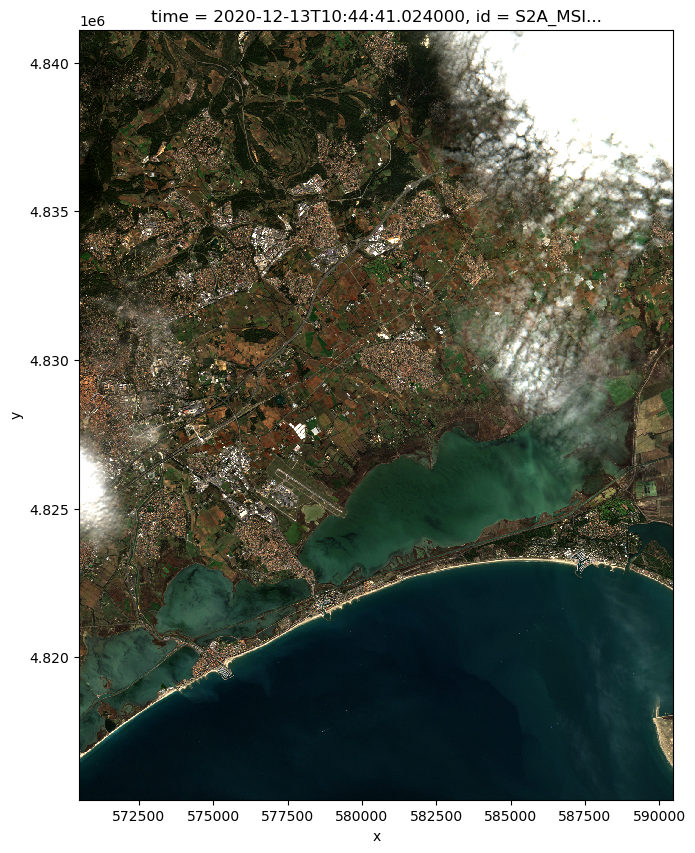

In [164]:
plt.figure(figsize=(15, 10))
ds_bands.plot.imshow(vmax=2900)
plt.gca().set_aspect('equal')
plt.show()

As a recap below are some short snippets to do some quick visualization. Keep in mind that Xarray uses `matplotlib` under the hood, so it is possible to use it in order to customize some aspects directly before calling `plt.show()` (and  we've done so already):

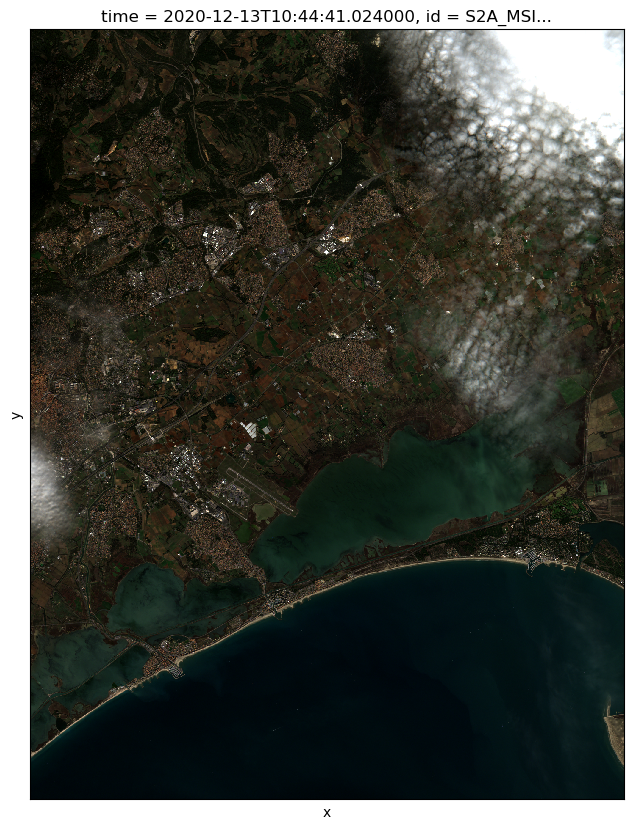

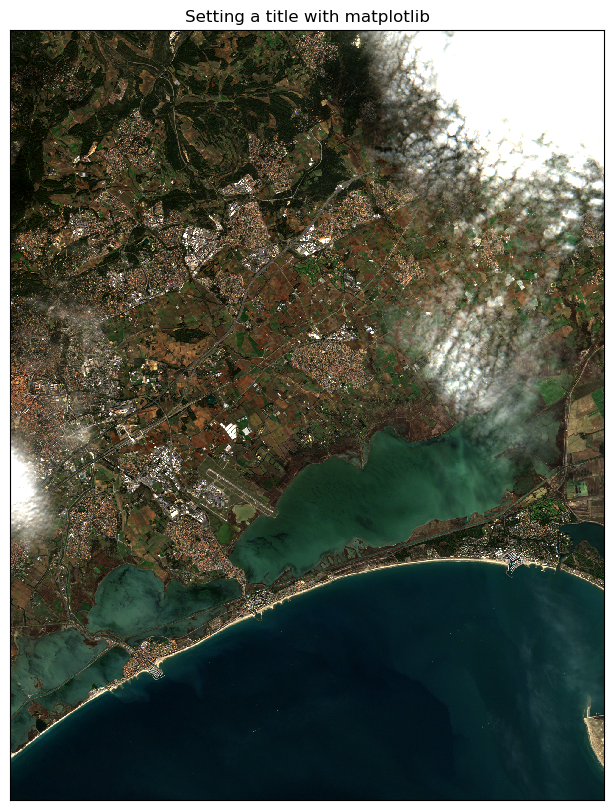

In [165]:
# removing the time dimension
# with size 1 with squeeze
ds_bands = array.squeeze()


plt.figure(figsize=(15, 10))
ds_bands[[2,1,0]].plot.imshow(robust=True, xticks=[])
plt.gca().set_aspect('equal')
# removing the axis ticks by setting them to an empty list
plt.yticks([])
plt.show()


# using matplotib object-oriented API
fig, ax = plt.subplots(figsize=(15,10))
# we use the `ax` parameter to specify the Axes object to plot on
ds_bands.loc[['B04','B03','B02']].plot.imshow(ax=ax, vmax=2900)
# setting the aspect ratio
ax.set_aspect('equal')
# removing the axis ticks and labels
# turning the axis off completely would work
# but it would also remove the black frame around the image
#ax.axis('off')

# removing the ticks and their labels
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
# removing 'x' and 'y' axis labels
ax.set(xlabel=None)
ax.set(ylabel=None)
# adding a title
ax.set_title('Setting a title with matplotlib')

fig.show()

## 8. Extra: Accessing values, loading and `compute`

This section is not fundamental to understand xarrays. However it can provide some context on why some operations on xarrays are faster or slower.

> **Note:** The following code cells contain code warped in functions. These functions serve no purpose other than allowing to time their execution with the `@timeit` decorator.

In [136]:
# used to time code execution at the end of the notebook
from functools import wraps
import time
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

Xarray has a lazy approach to computing when it comes to loading data. This means that the multi-dimensional array is not loaded into memory unless it is expressly needed. In this notebook we've learned about dimensions and coordinates. We've also seen how to filter an xarray. However, as long as we work on the dimensions or coordinates, there was no need to access the data itself, i.e. the underlying multi-dimensional array.

In fact, in this notebook there is only one situation in which we've had to access the multi-dimensional array: when we accessed it directly by using the `values` method. Here's the first instance where we did that:

In [137]:
array2 = array.copy(deep=True)

@timeit
def access_values():
    print(f"Value before assignment: {array2.loc[dict(band='B02', x=570490, y=4841100)].values}")
access_values()

Value before assignment: [104.]
Function access_values() {} Took 0.9758 seconds


However, the call to `values` was done after we selected a pixel by using dimensions. Thus we didn't have to load the whole array in memory, only the relevant part. In this situation we had a single pixel to assign, but since data is loaded in chunks, the whole chunk that the pixel belongs to was downloaded and loaded into memory. This explains why the previous cell only took little time to execute.

If we use `values` without limiting the selection beforehand, this will download the whole array which is much slower:

In [138]:
@timeit
def access_values2():
    array.values
access_values2()

Function access_values2() {} Took 5.4524 seconds


There are some instances where the naive assumption is that the array data *must* have been loaded. For instance in the next cell it is reasonable to assume that the whole array has to be downloaded:

In [139]:
@timeit
def create_where():
    return xr.where(array%2, array, 2*array)
where_array = create_where()
where_array

Function create_where() {} Took 0.0040 seconds


<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 373MB
dask.array<where, shape=(1, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631

Despite our assumption the execution was quite fast. The explanation is that until we actually need to access the values of the array, there is no need to actually apply the boolean condition defined in `xarray.where`. For lack of a better word, this condition is virtual until we actually access the values:

In [140]:
@timeit
def access_values3():
    where_array.values
access_values3()

Function access_values3() {} Took 5.8870 seconds


It is technically possible to forcibly load an array into memory by using the `compute` method which will return a new xarray with the data loaded. However there are few situations where this is necessary. One obvious reason would be frequents call to `values`, but that is usually the sign that the code should be rewritten to avoid these frequents calls.

In [141]:
# calling compute and returning the loaded array
@timeit
def compute():
    return array.compute()
where_array2 = compute()

Function compute() {} Took 6.4548 seconds


In [142]:
# applying xr.where on an already-loaded array
@timeit
def where_on_loaded_xarray():
    return xr.where(where_array2 % 2, where_array2, 2*where_array2)
where_on_loaded_xarray()

Function where_on_loaded_xarray() {} Took 2.3009 seconds


<xarray.DataArray 'stackstac-6c38b4e290bbf99cb8223967bf30f04d' (time: 1,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 373MB
array([[[[2.0800e+02, 1.6900e+02, 2.6800e+02, ..., 7.9640e+03,
          7.8720e+03, 7.8920e+03],
         [4.7200e+02, 2.3500e+02, 5.4400e+02, ..., 7.9120e+03,
          7.8120e+03, 7.9400e+03],
         [4.7200e+02, 2.0700e+02, 4.0400e+02, ..., 7.8360e+03,
          7.8560e+03, 7.8360e+03],
         ...,
         [5.6800e+02, 5.4800e+02, 2.6500e+02, ..., 4.2500e+02,
          8.3600e+02, 8.4800e+02],
         [4.9600e+02, 4.5200e+02, 2.4500e+02, ..., 8.7200e+02,
          9.1600e+02, 4.3500e+02],
         [2.6300e+02, 2.1900e+02, 4.3200e+02, ..., 4.2100e+02,
          4.2900e+02, 9.1600e+02]],

        [[5.3600e+02, 6.5200e+02, 3.0100e+02, ..., 7.7880e+03,
          7.6800e+03, 7.6960e+03],
         [4.0300e+02, 8.2400e+02, 4.7300e+02, ..., 7.6480e+03,
          7.7360e+03, 7.7640e+03],
         [8.3200e+02, 3.8100e+02, 3.2300e+02, ..., 7.8400e+03,
          7.8320e+03, 7.8040e+03],
...
         [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 5.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 5.0000e+00, 5.0000e+00, ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 5.0000e+00, 5.0000e+00, ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00]],

        [[5.8100e+02, 6.3100e+02, 6.3100e+02, ..., 5.4920e+03,
          5.4640e+03, 5.4640e+03],
         [5.8100e+02, 6.3100e+02, 6.3100e+02, ..., 5.4920e+03,
          5.4640e+03, 5.4640e+03],
         [1.2840e+03, 1.2680e+03, 1.2680e+03, ..., 2.7430e+03,
          5.4680e+03, 5.4680e+03],
         ...,
         [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 2.4000e+01,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 3.0000e+00,
          7.0000e+00, 7.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 3.0000e+00,
          7.0000e+00, 7.0000e+00]]]])
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 8B 2020-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    sat:relative_orbit                       int64 8B 8
    ...                                       ...
    gsd                                      (band) float64 72B 10.0 ... 20.0
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631